<a href="https://colab.research.google.com/github/Evans-tats/machine-learning/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')
SEED = 42


In [187]:
def concat_df(train_data, test_data):
  train_data = train_data.reset_index(drop=True)
  test_data = test_data.reset_index(drop=True)
  return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
  return all_data.loc[:890], all_data.loc[891:].drop(["Survived"], axis=1)

df_train = pd.read_csv("/content/sample_data/train (1).csv")
df_test = pd.read_csv("/content/sample_data/test (1).csv")

all_data = concat_df(df_train,df_test)

df_train.name = "Traning Set"
df_test.name = "Test Set"
all_data.name = "ALL set"

dfs = [df_train, df_test]

print('Number of training Examples = {}' .format(df_train.shape[0]))
print('Number of test Examples = {}\n' .format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

df_test.shape[0]


Number of training Examples = 891
Number of test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


418

In [188]:
df_train.info()
df_train.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [189]:
def missing_value(all_data):
  for col in all_data.columns.tolist():
    print("{} column missing values: {}".format(col, all_data[col].isnull().sum()))
    print('\n')

In [190]:
for df in dfs:
  missing_value(df)
  print('\n')

PassengerId column missing values: 0


Survived column missing values: 0


Pclass column missing values: 0


Name column missing values: 0


Sex column missing values: 0


Age column missing values: 177


SibSp column missing values: 0


Parch column missing values: 0


Ticket column missing values: 0


Fare column missing values: 0


Cabin column missing values: 687


Embarked column missing values: 2




PassengerId column missing values: 0


Pclass column missing values: 0


Name column missing values: 0


Sex column missing values: 0


Age column missing values: 86


SibSp column missing values: 0


Parch column missing values: 0


Ticket column missing values: 0


Fare column missing values: 1


Cabin column missing values: 327


Embarked column missing values: 0






In [191]:
df_all_corr = all_data.select_dtypes(include=["float64", "int64"]).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation Coefficient"}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
10,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [192]:
age_by_pclass_sex = all_data.groupby(['Sex','Pclass'])["Age"].median()
#print(age_by_pclass_sex)
for pclass in range(1,4):
  for sex in ['female','male']:
    print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print("median age of all passengers: {}". format(all_data["Age"].median()))

all_data['Age'] = all_data.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
median age of all passengers: 28.0


In [193]:
all_data['Embarked'] = all_data['Embarked'].fillna('S')


In [194]:
med_fare = all_data.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()
med_fare_value = med_fare.loc[3,0,0]
all_data['Fare'] = all_data['Fare'].fillna(med_fare_value)


In [195]:
from typing import ValuesView
all_data.drop(["Cabin"], inplace=True, axis=1)

df_train, df_test = divide_df(all_data)
dfs = [df_train, df_test]

for df in dfs:
  missing_value(df)

Age column missing values: 0


Embarked column missing values: 0


Fare column missing values: 0


Name column missing values: 0


Parch column missing values: 0


PassengerId column missing values: 0


Pclass column missing values: 0


Sex column missing values: 0


SibSp column missing values: 0


Survived column missing values: 0


Ticket column missing values: 0


Age column missing values: 0


Embarked column missing values: 0


Fare column missing values: 0


Name column missing values: 0


Parch column missing values: 0


PassengerId column missing values: 0


Pclass column missing values: 0


Sex column missing values: 0


SibSp column missing values: 0


Ticket column missing values: 0




342 of 891 passengers survived and it is the 38.38% of the training set. 
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


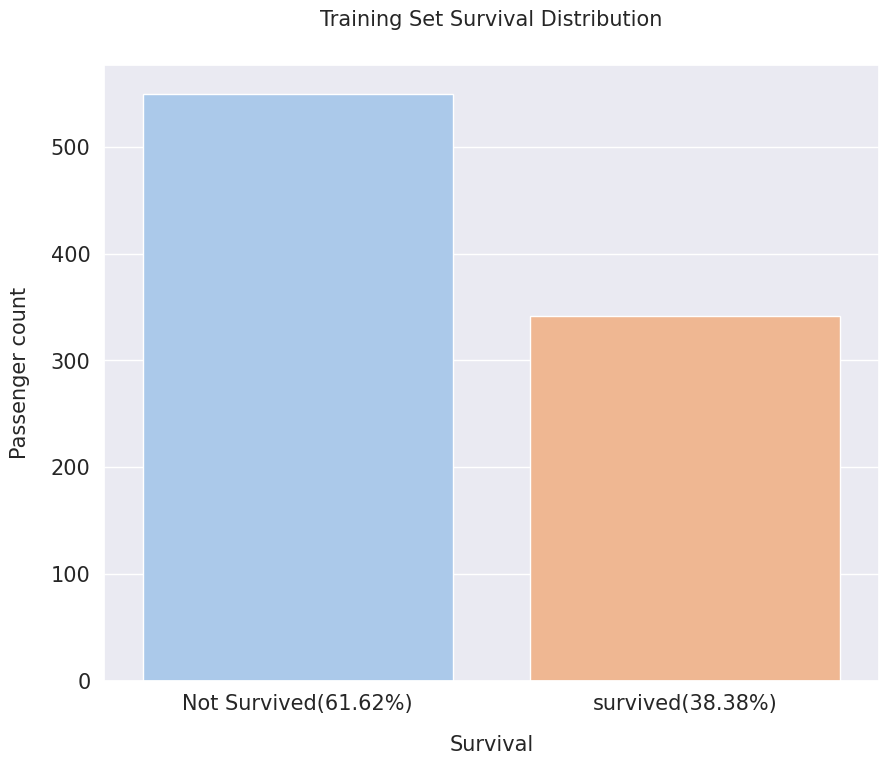

In [196]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set. '
.format(survived, df_train.shape[0], survived_per))

print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'
.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10,8))
sns.countplot(x="Survived", data=df_train, palette='pastel')


plt.xlabel("Survival", size=15, labelpad=15)
plt.ylabel("Passenger count", size=15, labelpad=15)
plt.xticks((0,1),
 ['Not Survived({0:.2f}%)'.format(not_survived_per),
  'survived({0:.2f}%)'.format(survived_per)])
# plt.xticks((0,1),
#  ['Not Survived({0:.2f}%)'.format(not_survived_per),
#   'survived({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Training Set Survival Distribution', size=15, y=1.05)
plt.show()

In [197]:
df_train_corr = df_train.select_dtypes(include=["float64", "int64"]).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
# df_train_corr = df_train.corr().abs().unstack().sort_value(kind='quicksort', ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1" : "Feature 2", 0: "correlation Coefficient"}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.select_dtypes(include=["float64", "int64"]).corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1" : "Feature 2", 0: "correlation Coefficient"}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['correlation Coefficient'] == 1.0].index)

In [198]:
corr = df_train_corr_nd['correlation Coefficient'] > 0.1
df_train_corr_nd[corr]



,Feature 1,Feature 2,correlation Coefficient
8,Pclass,Fare,0.549500
10,Age,Pclass,0.417667
12,Parch,SibSp,0.414838
14,Pclass,Survived,0.338481
16,Survived,Fare,0.257307
18,SibSp,Age,0.249747
20,Fare,Parch,0.216225
22,Age,Parch,0.176733
24,Fare,SibSp,0.159651
26,Age,Fare,0.124061


In [199]:
corr =df_test_corr['correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,correlation Coefficient
6,Fare,Pclass,0.577489
8,Pclass,Age,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,Fare,SibSp,0.172032


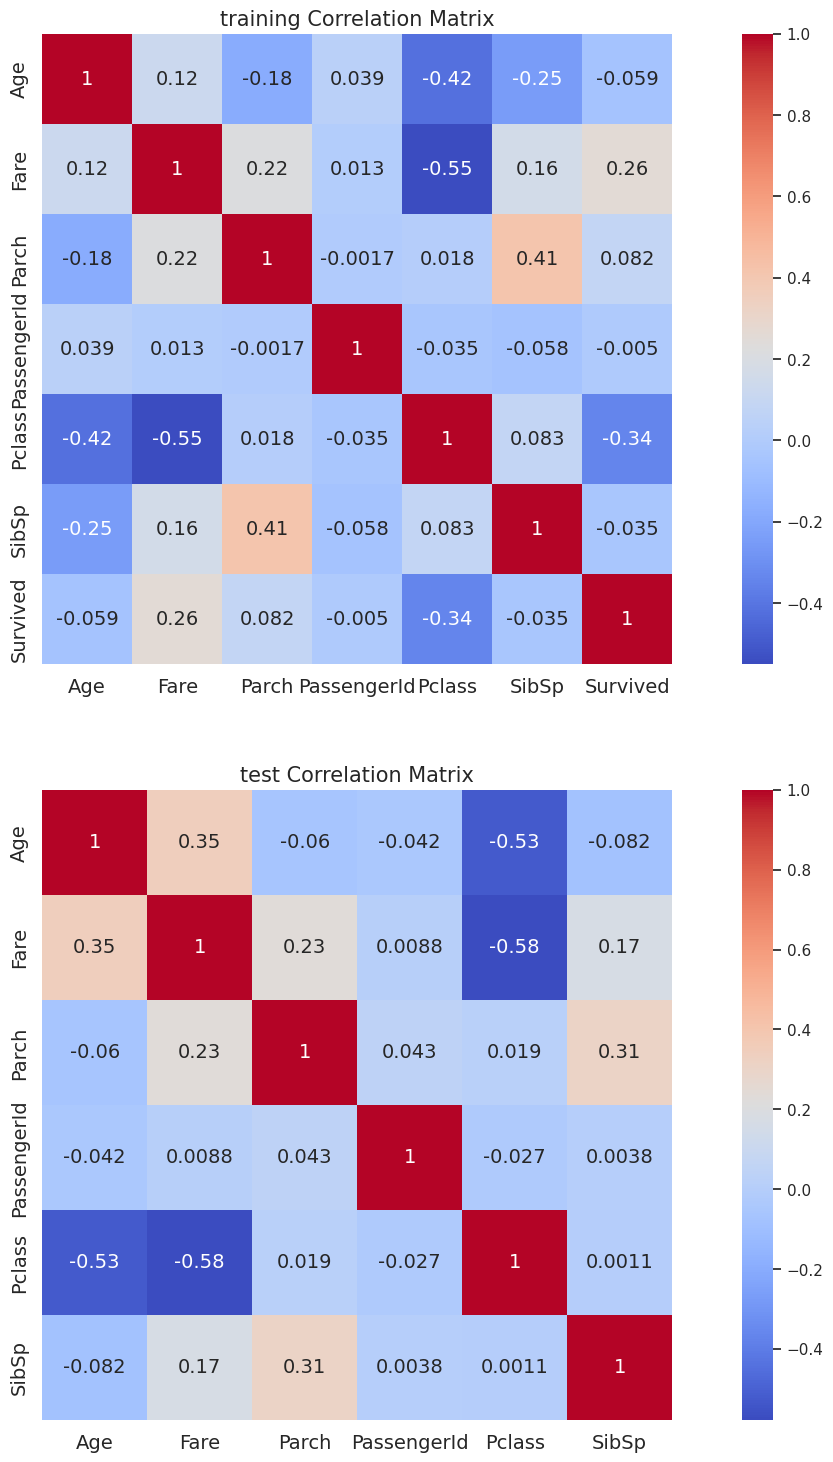

In [200]:
fig, axs =plt.subplots(nrows=2, figsize=(18,18))

sns.heatmap(df_train.select_dtypes(["float64", "int64"]).corr(),
            ax=axs[0],
            annot=True,
            square=True,
            cmap='coolwarm',
            annot_kws={'size': 14})
sns.heatmap(df_test.select_dtypes(["float64", "int64"]).corr(),
            ax=axs[1],
            annot=True,
            square=True,
            cmap='coolwarm',
            annot_kws={'size': 14})

for i in range(2):
  axs[i].tick_params(axis='x', labelsize=14)
  axs[i].tick_params(axis='y', labelsize=14)

axs[0].set_title('training Correlation Matrix', size=15)
axs[1].set_title('test Correlation Matrix', size=15)

plt.show()

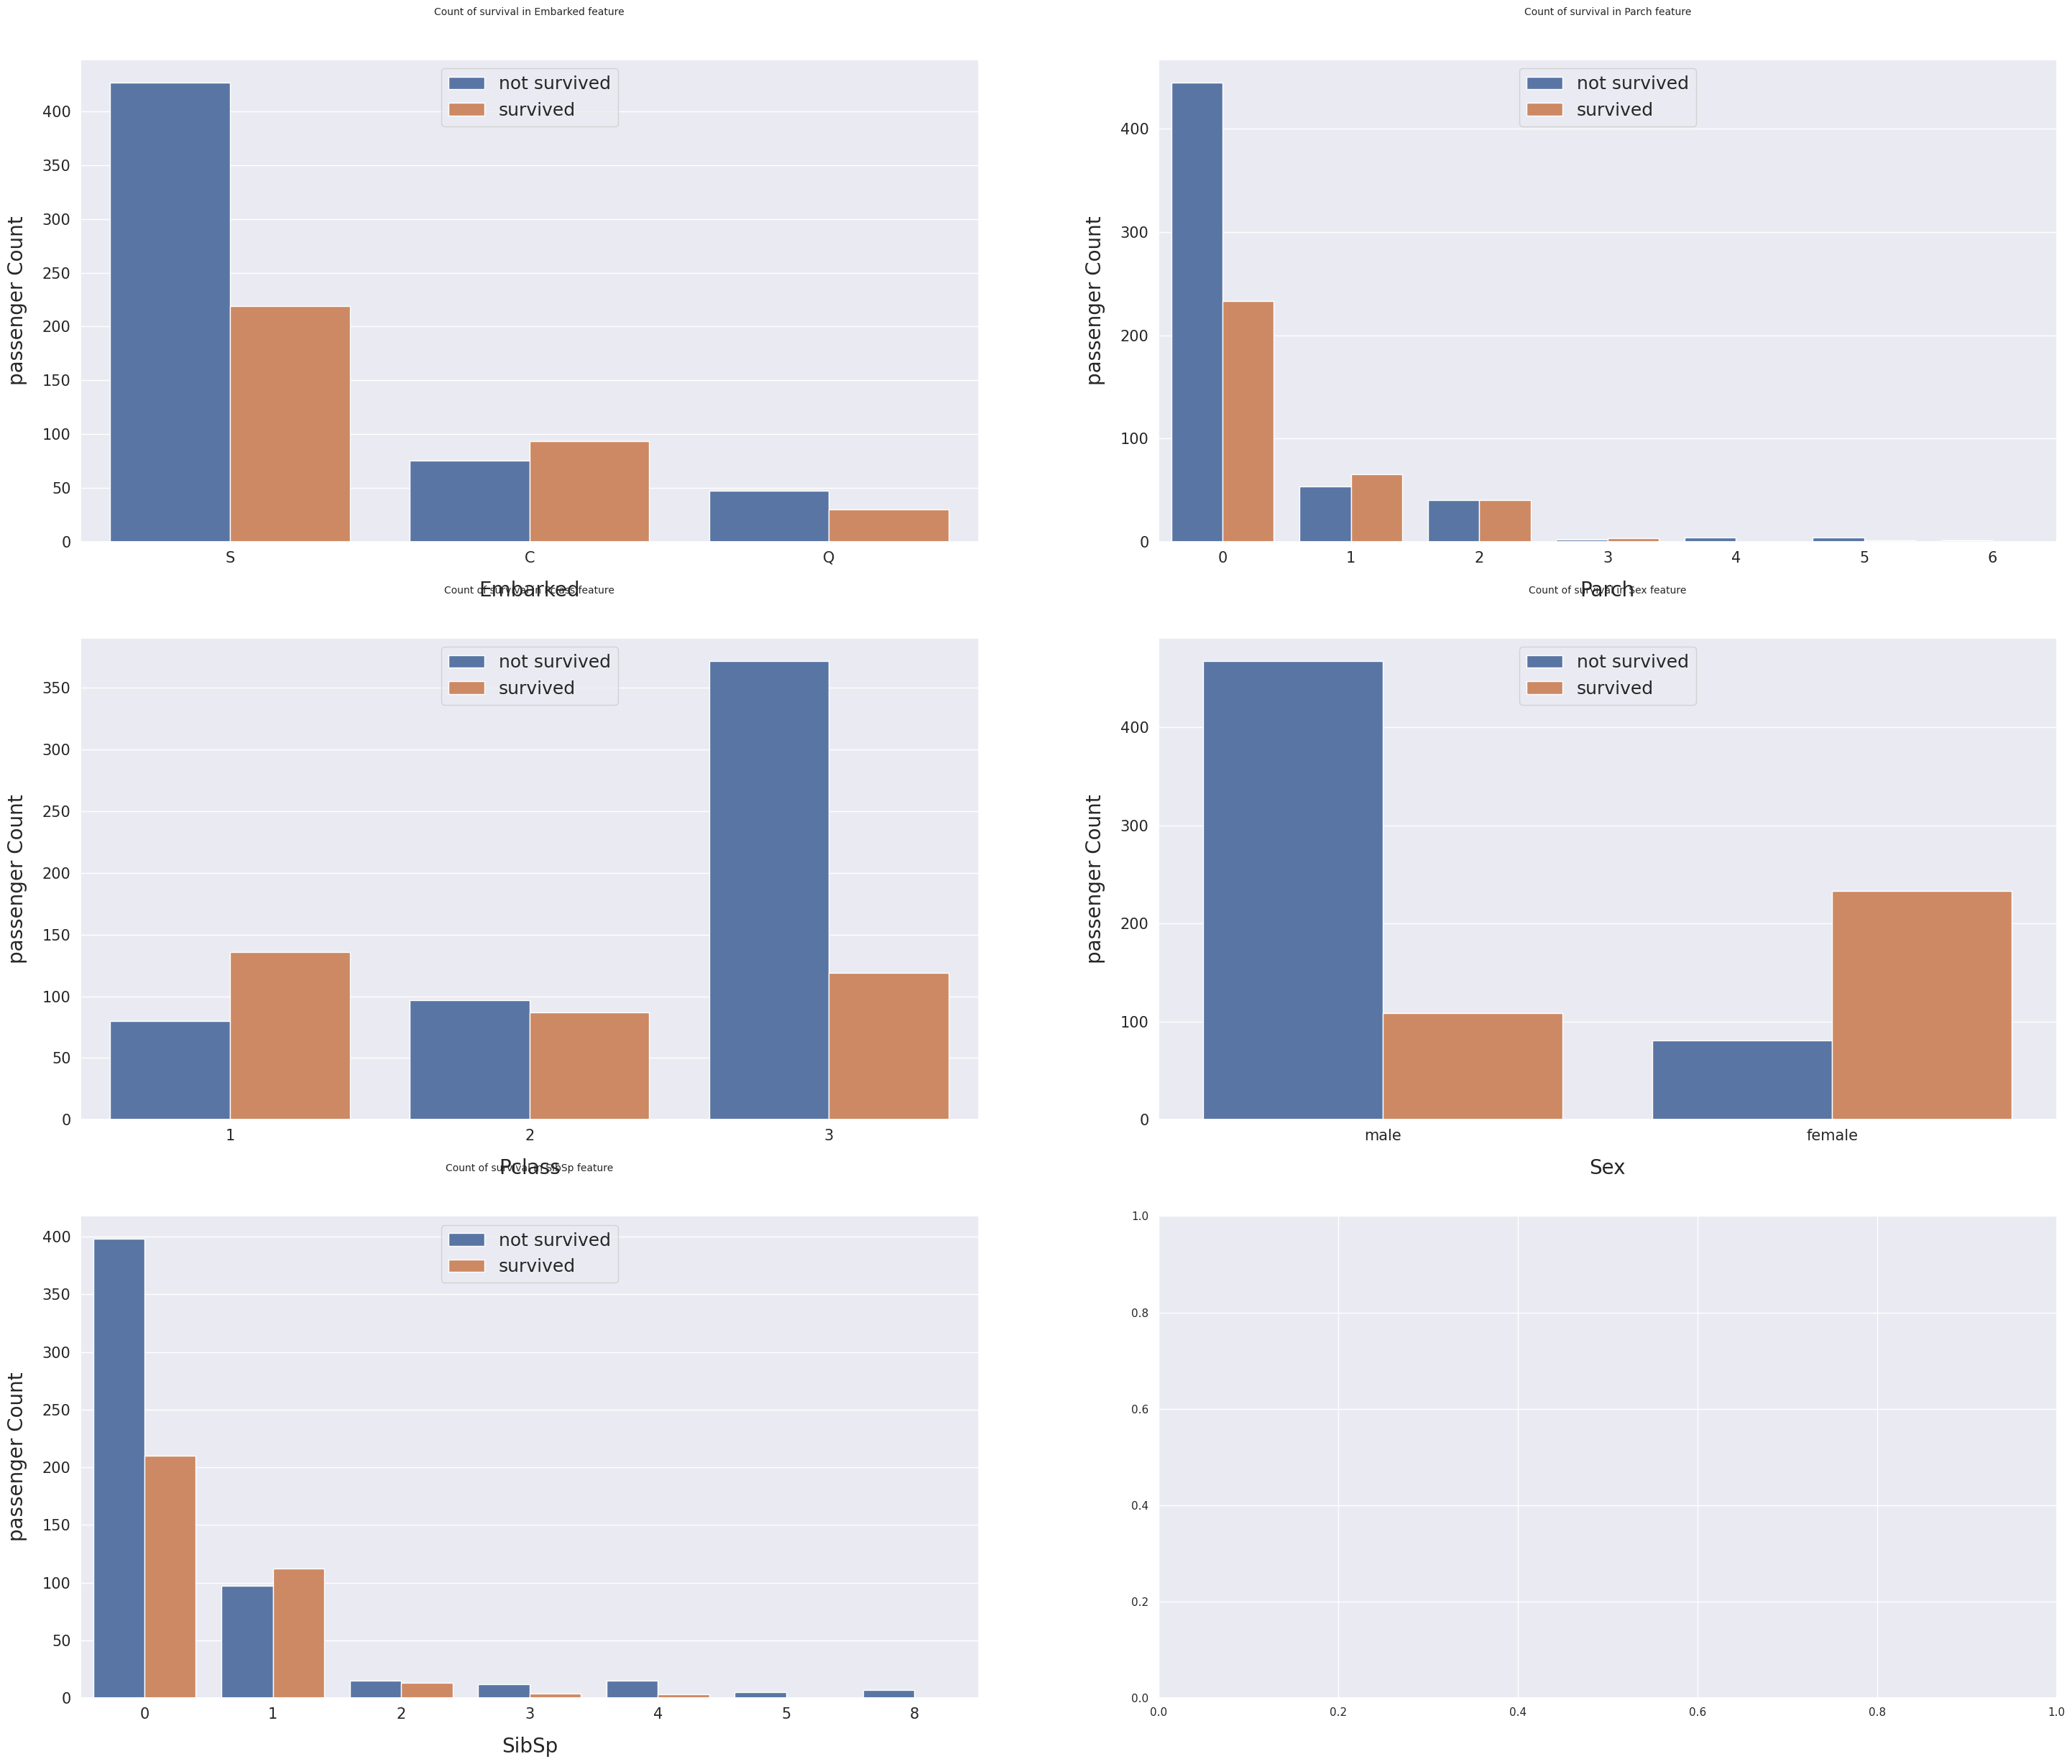

In [201]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
  plt.subplot(3, 2, i)
  sns.countplot(data=df_train, x=feature, hue='Survived')
  plt.xlabel('{}'.format(feature), size=20, labelpad=15)
  plt.ylabel('passenger Count', size=20, labelpad=15)
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=15)

  plt.legend(['not survived', 'survived'], loc = 'upper center', prop={'size':18})
  plt.title('Count of survival in {} feature'.format(feature), size=10, y=1.08)

plt.show()

In [202]:
all_data['Fare'] = pd.qcut(all_data['Fare'], 13)


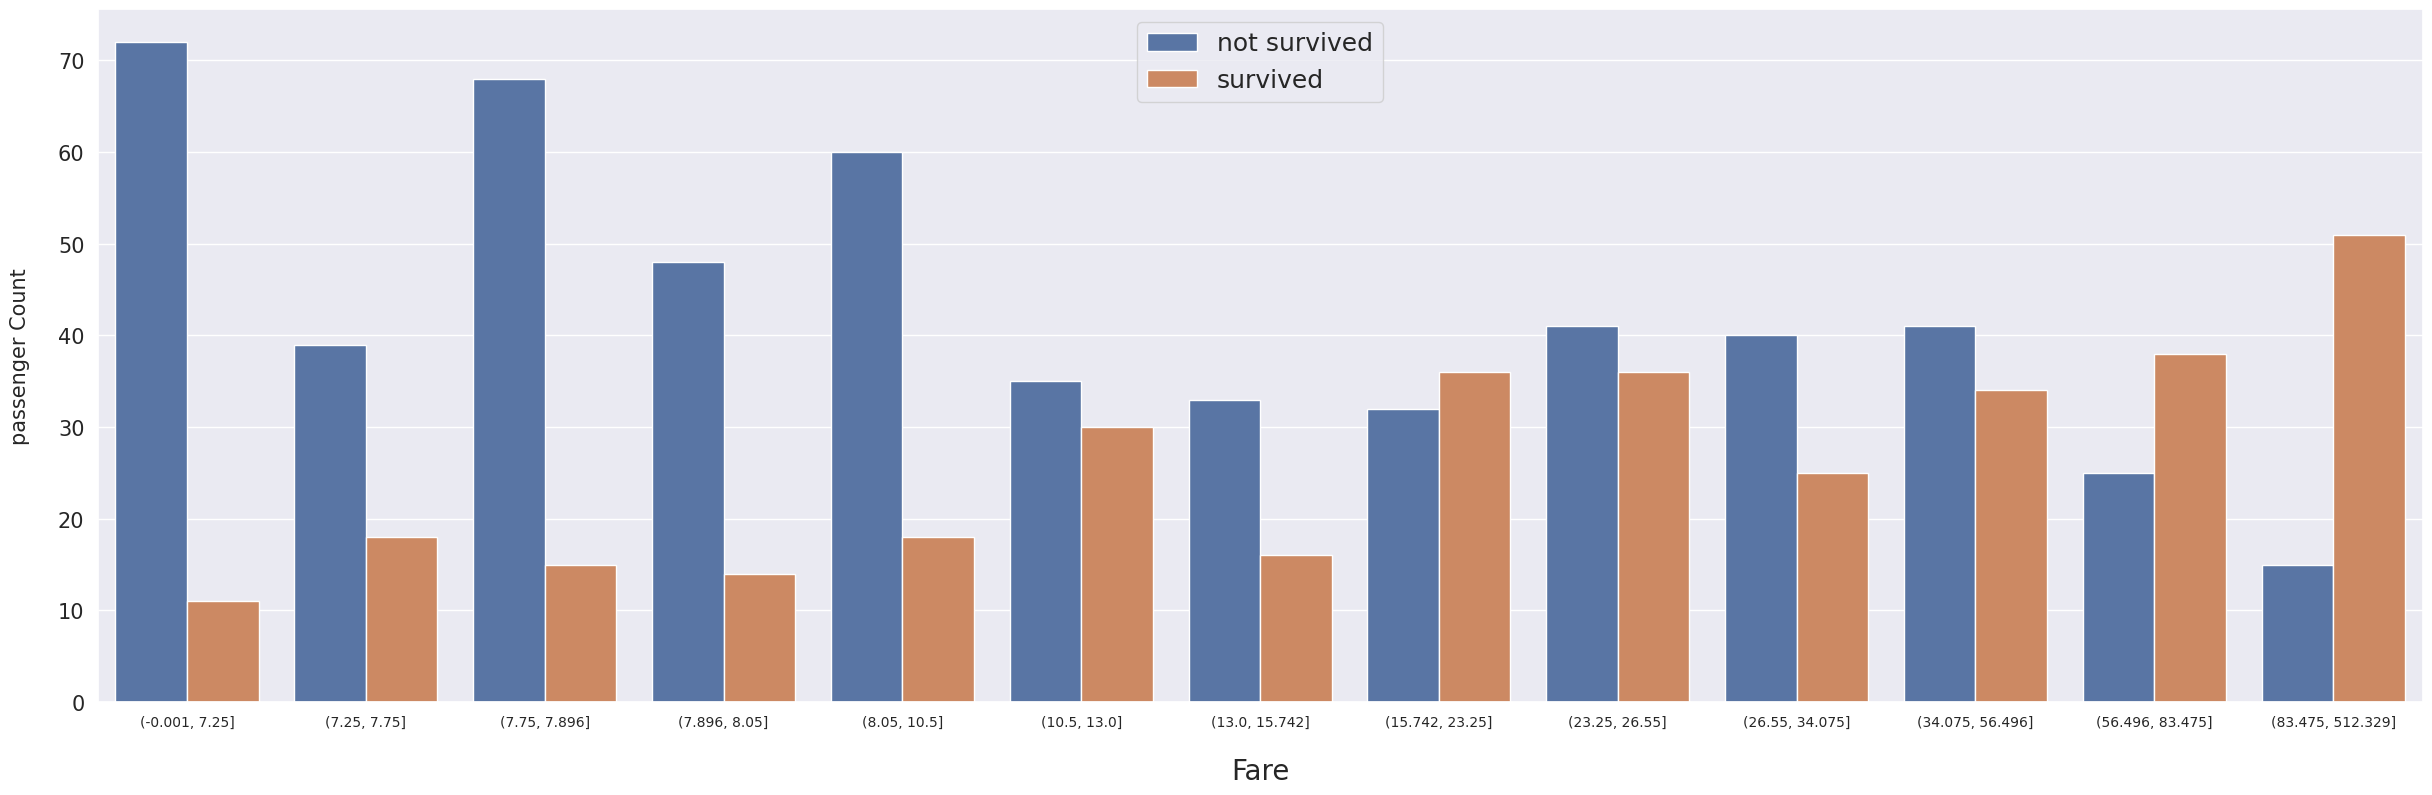

In [203]:
fig, axs = plt.subplots(figsize=(30,9))
sns.countplot(data=all_data, x='Fare', hue='Survived')

plt.xlabel('Fare', size=20, labelpad=20)
plt.ylabel('passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['not survived', 'survived'], loc = 'upper center', prop={'size':18})
plt.show()

In [204]:
all_data['Age'] = pd.qcut(all_data['Age'], 10)


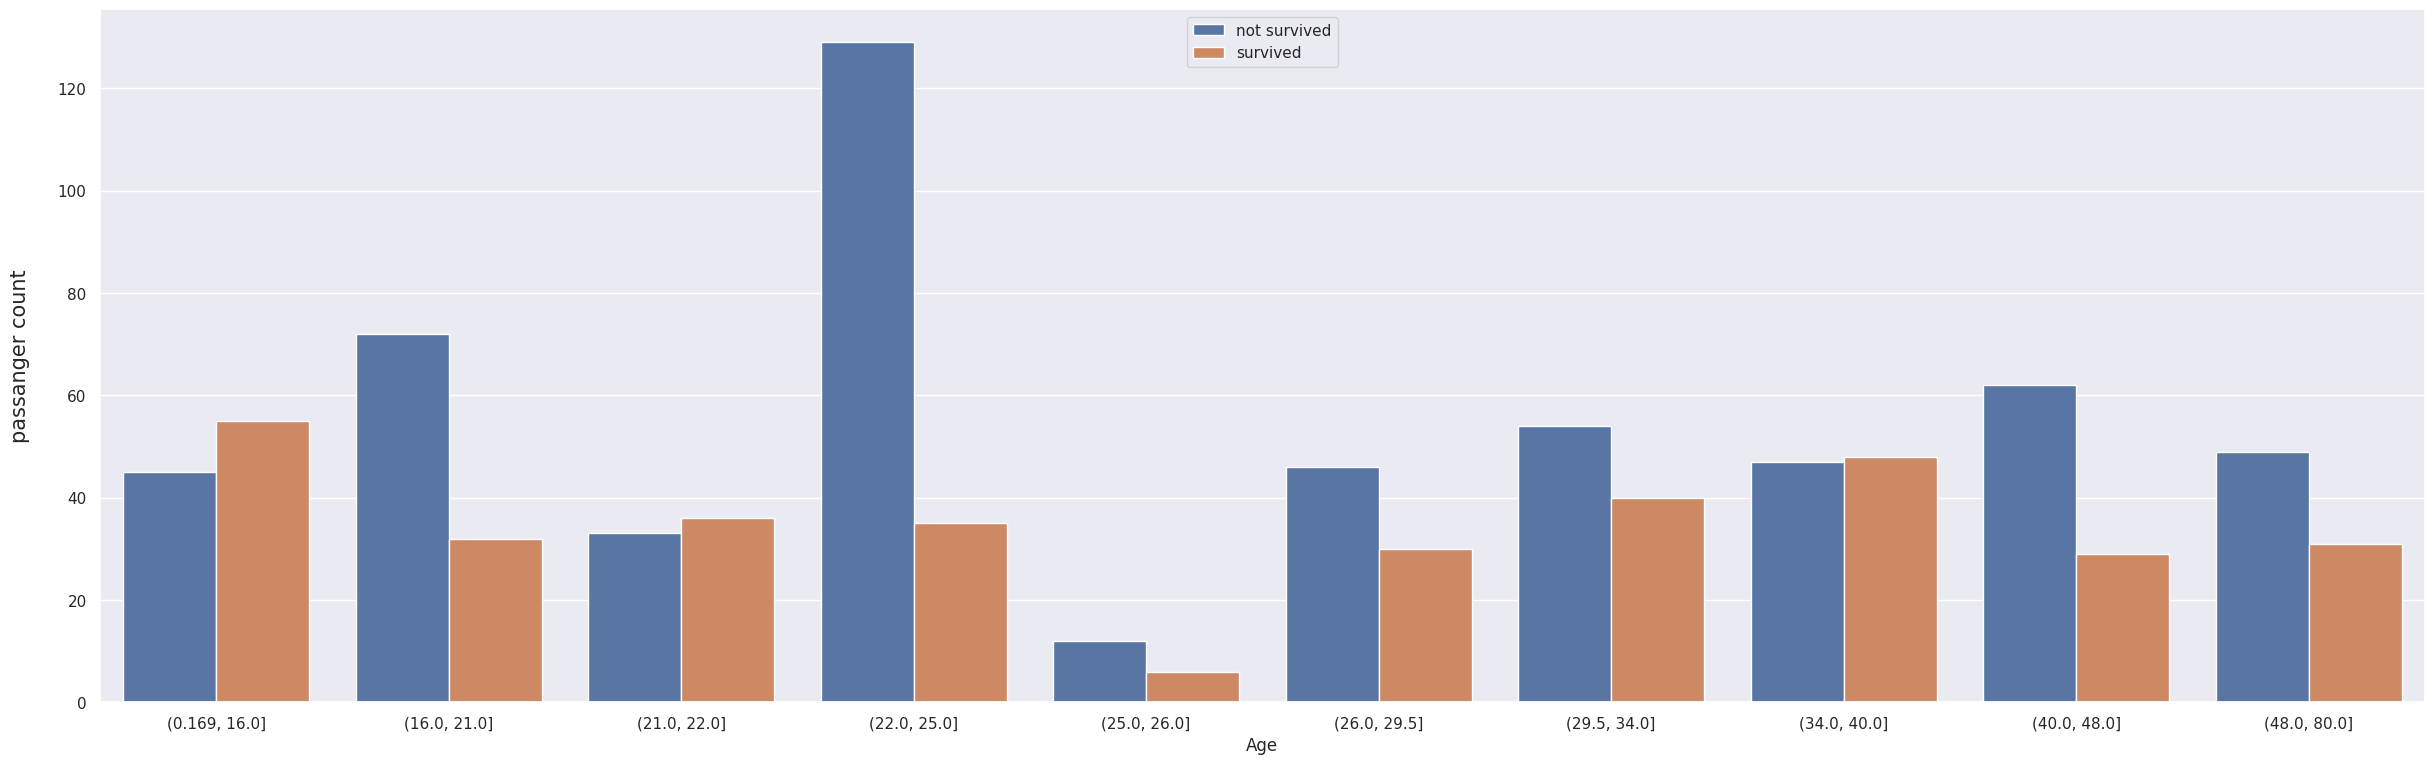

In [205]:
fig, axs = plt.subplots(figsize=(30,9))
sns.countplot(data=all_data, x='Age', hue='Survived')

plt.ylabel('passanger count', size=15, labelpad=20)

plt.legend(['not survived', 'survived'], loc= 'upper center')
plt.show()

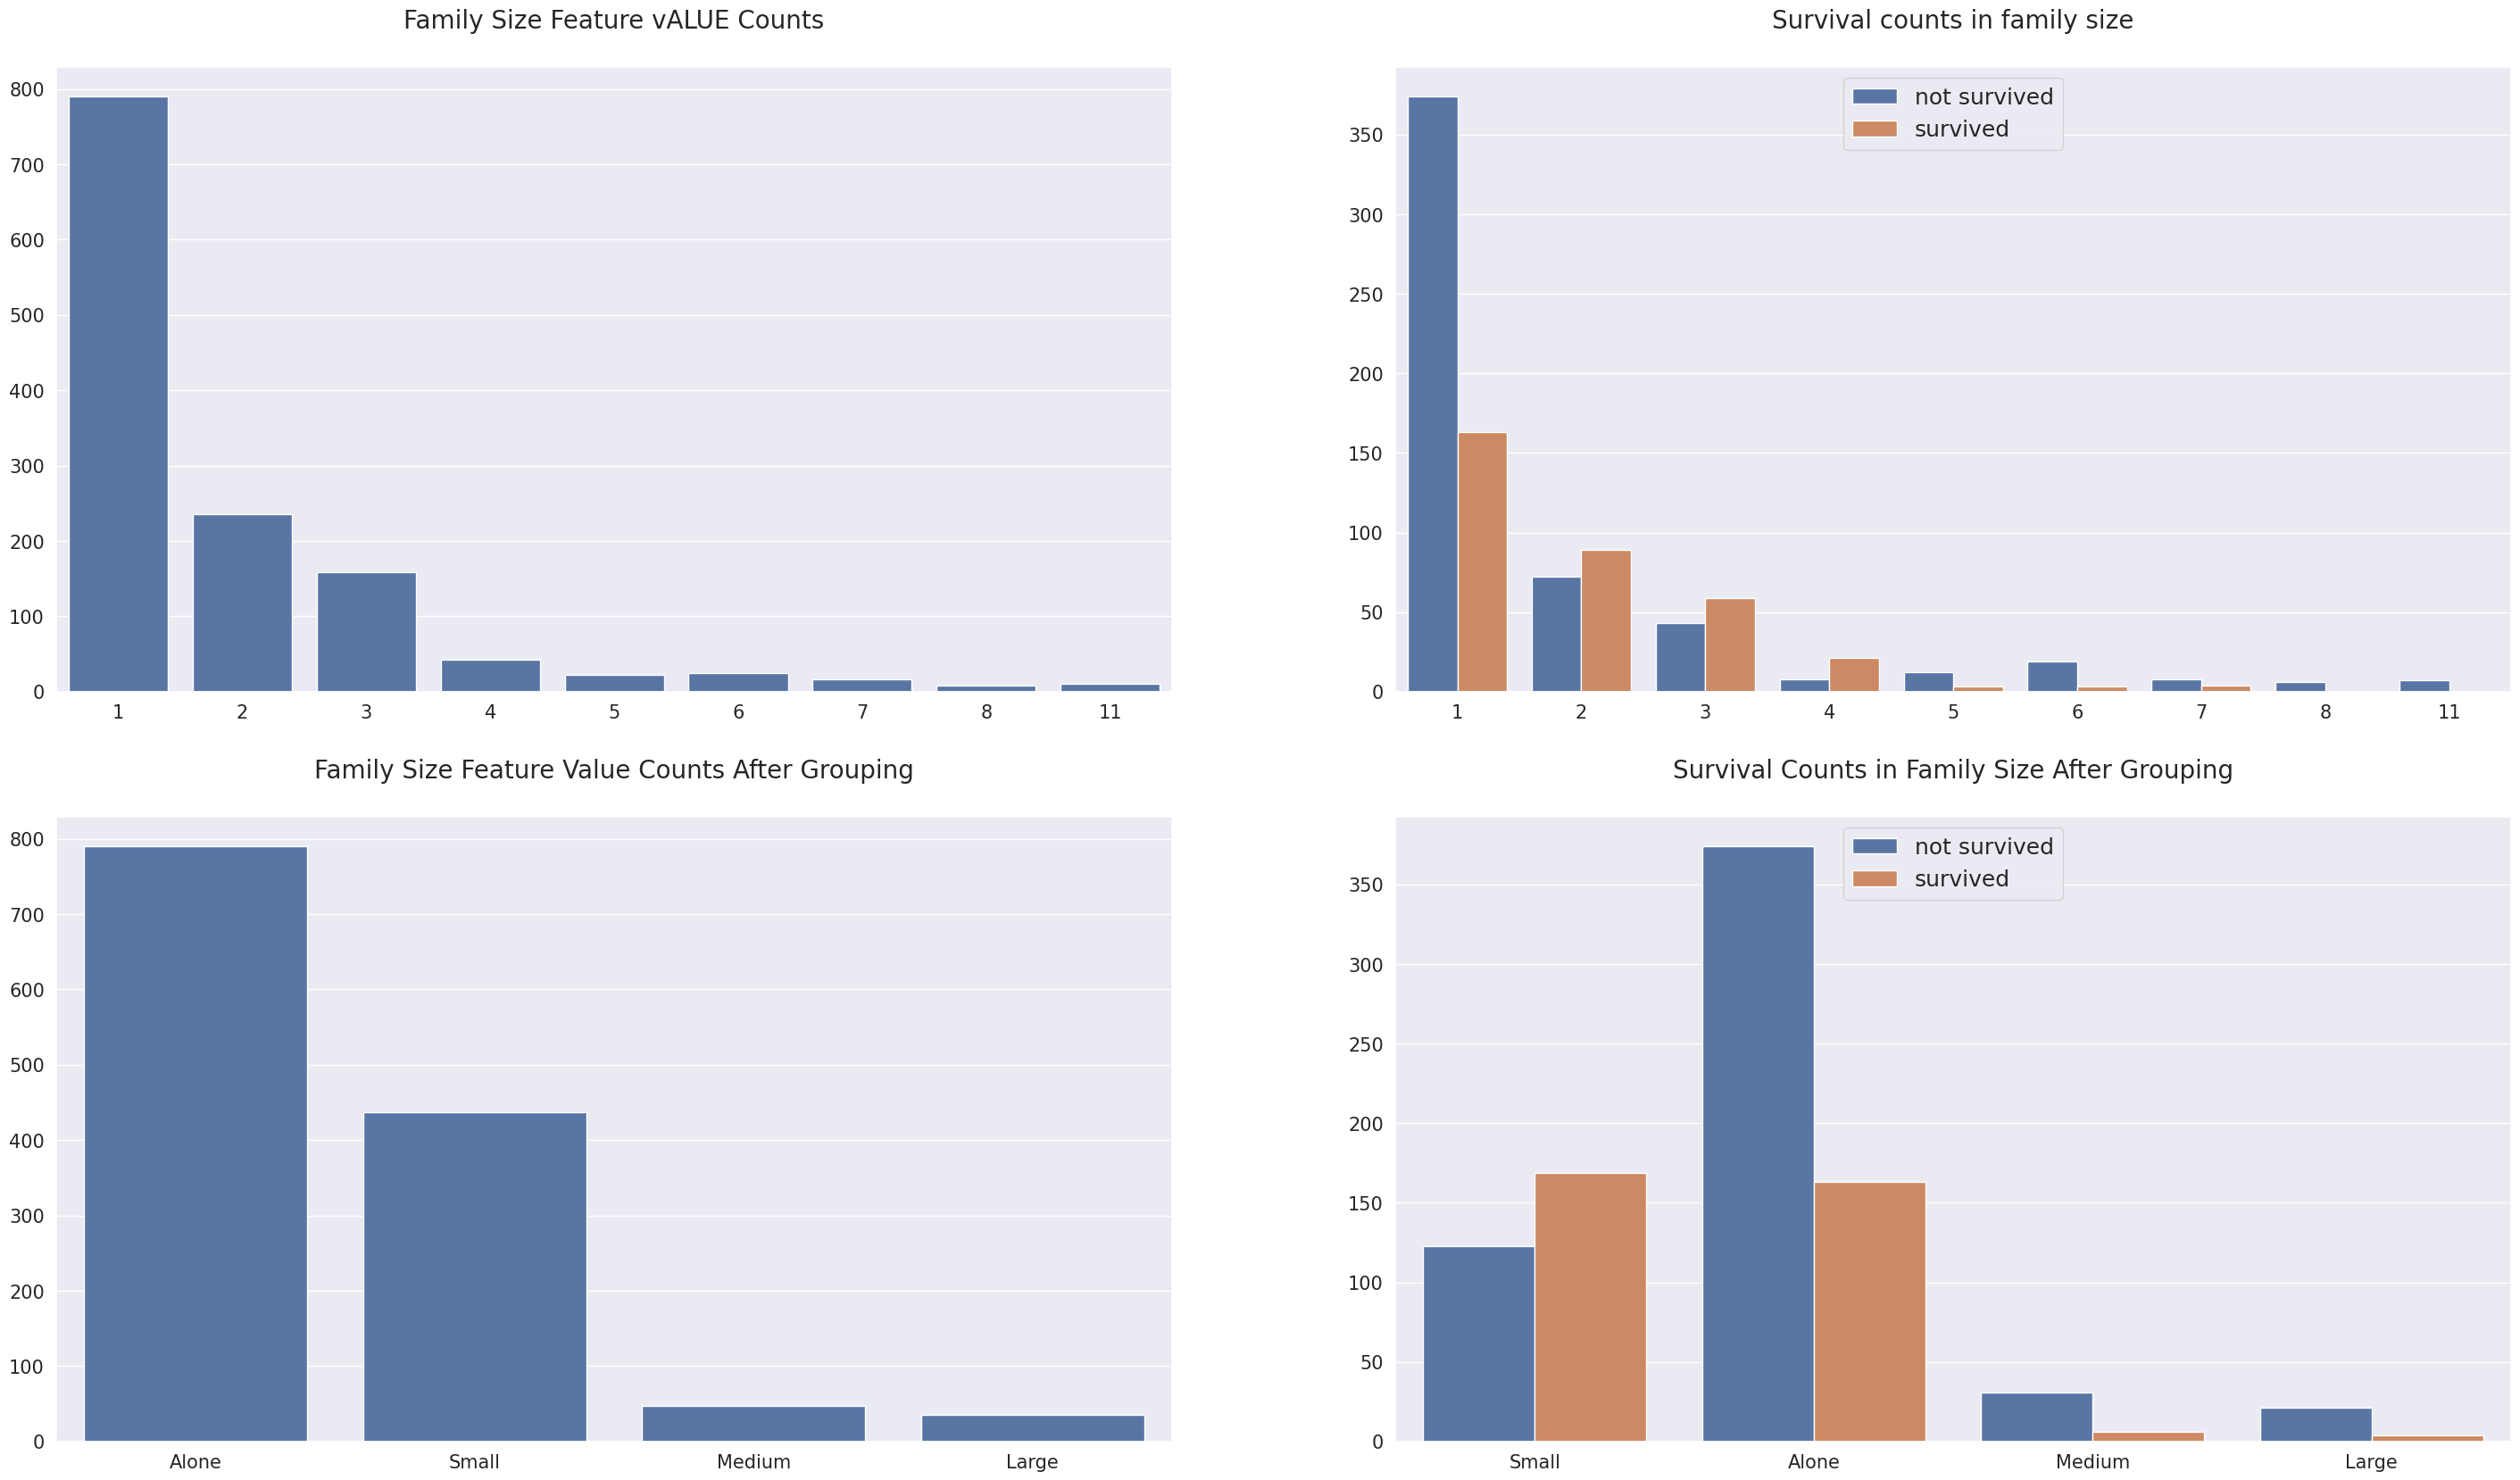

In [206]:
all_data['Family_Size'] = all_data['SibSp'] + all_data['Parch'] + 1

fig, axs = plt.subplots(figsize=(20,20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=all_data['Family_Size'].value_counts().index,
            y=all_data['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue="Survived", data=all_data, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature vALUE Counts', size=20, y=1.05)
axs[0][1].set_title('Survival counts in family size', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
all_data['family_size_grouped'] = all_data['Family_Size'].map(family_map)
x=all_data['family_size_grouped'].value_counts().index,

sns.barplot(x=all_data['family_size_grouped'].value_counts().index,
            y=all_data['family_size_grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='family_size_grouped', hue='Survived', data=all_data, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
  axs[i][1].legend(['not survived', 'survived'], loc='upper center', prop={'size':18})
  for j in range(2):
    axs[i][j].tick_params(axis='x', labelsize=15)
    axs[i][j].tick_params(axis='y', labelsize=15)
    axs[i][j].set_xlabel('')
    axs[i][j].set_ylabel('')
plt.show()


In [207]:
all_data['Ticket_Frequency'] = all_data.groupby('Ticket')['Ticket'].transform('count')


Text(0.5, 1.0, 'count of survival in ticket frequency feature')

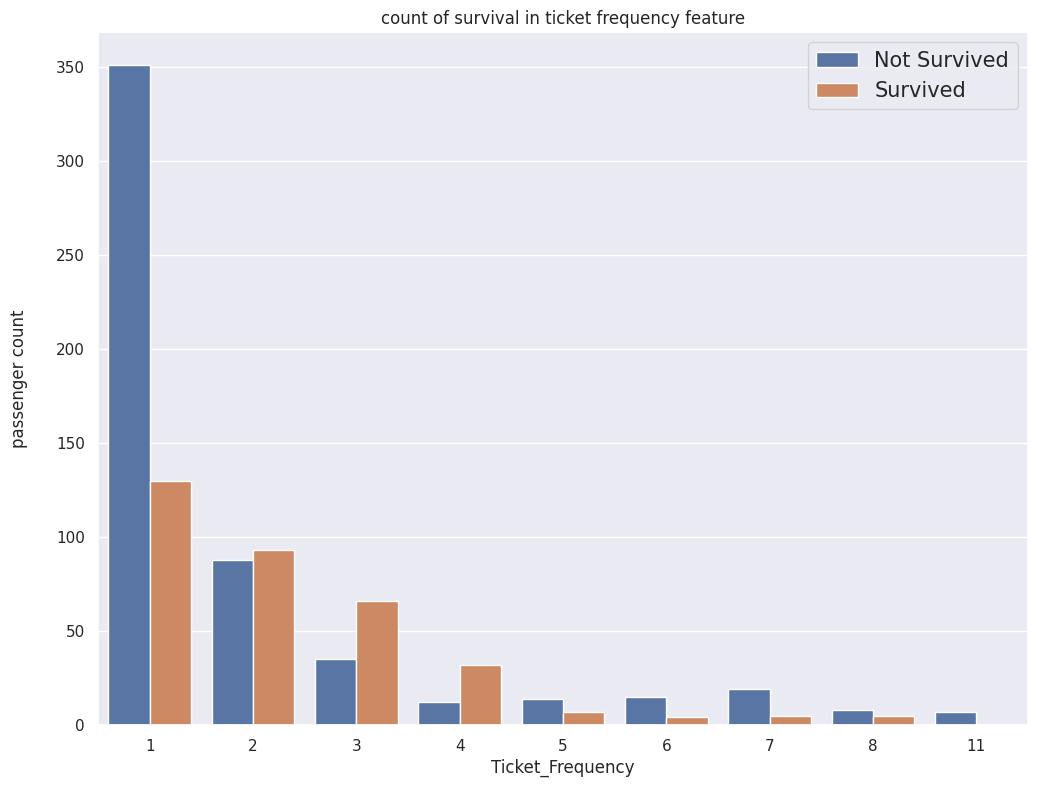

In [208]:
fig, axs = plt.subplots(figsize=(12,9))
sns.countplot(data=all_data, x='Ticket_Frequency', hue='Survived')

plt.ylabel('passenger count', labelpad=20)
plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title("count of survival in ticket frequency feature")


In [209]:
df_train,df_test = divide_df(all_data)
dfs = [df_train, df_test]

In [210]:
# df_train = all_data.loc[:890]
# df_test = all_data.loc[891:]
# dfs = [df_train, df_test]

In [211]:
non_numeric_features = ['Embarked', 'Sex', 'family_size_grouped', 'Age', 'Fare']

for df in dfs:
  for feature in non_numeric_features:
    df[feature] = LabelEncoder().fit_transform(df[feature])


In [214]:
from sklearn.preprocessing import OneHotEncoder

cat_features = ['Pclass', 'Sex', 'Embarked', 'family_size_grouped']

# Separate lists for train and test
encoded_train = []
encoded_test = []

for feature in cat_features:
    # Combine both datasets to ensure consistent encoding
    combined = pd.concat([df_train[feature], df_test[feature]])
    encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
    encoder.fit(combined.values.reshape(-1, 1))

    # Transform train
    train_encoded = encoder.transform(df_train[feature].values.reshape(-1, 1))
    train_cols = [f'{feature}_{cat}' for cat in encoder.categories_[0]]
    encoded_train.append(pd.DataFrame(train_encoded, columns=train_cols, index=df_train.index))

    # Transform test
    test_encoded = encoder.transform(df_test[feature].values.reshape(-1, 1))
    encoded_test.append(pd.DataFrame(test_encoded, columns=train_cols, index=df_test.index))

# Concatenate encoded features to original dataframes
df_train = pd.concat([df_train] + encoded_train, axis=1)
df_test = pd.concat([df_test] + encoded_test, axis=1)


In [ ]:
# cat_features = ['Pclass','Sex','Embarked', 'family_size_grouped']
# encoded_feature = []

# for df in dfs:
#   for feature in cat_features:
#     encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1,1)).toarray()
#     n= df[feature].nunique()
#     cols = ['{}_{}'.format(feature,n)for n in range(1,n+1)]
#     encoded_df = pd.DataFrame(encoded_feat, columns=cols)
#     encoded_df.index = df.index
#     encoded_feature.append(encoded_df)

# df_train = pd.concat([df_train, *encoded_feature[:6]], axis=1)
# df_test = pd.concat([df_test, *encoded_feature[6:]], axis=1)


In [215]:
df_train.columns.tolist()

['Age',
 'Embarked',
 'Fare',
 'Name',
 'Parch',
 'PassengerId',
 'Pclass',
 'Sex',
 'SibSp',
 'Survived',
 'Ticket',
 'Family_Size',
 'family_size_grouped',
 'Ticket_Frequency',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_0',
 'Sex_1',
 'Embarked_0',
 'Embarked_1',
 'Embarked_2',
 'family_size_grouped_0',
 'family_size_grouped_1',
 'family_size_grouped_2',
 'family_size_grouped_3']

In [216]:
df_test.columns.tolist()

['Age',
 'Embarked',
 'Fare',
 'Name',
 'Parch',
 'PassengerId',
 'Pclass',
 'Sex',
 'SibSp',
 'Ticket',
 'Family_Size',
 'family_size_grouped',
 'Ticket_Frequency',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_0',
 'Sex_1',
 'Embarked_0',
 'Embarked_1',
 'Embarked_2',
 'family_size_grouped_0',
 'family_size_grouped_1',
 'family_size_grouped_2',
 'family_size_grouped_3']

In [217]:
df_all = concat_df(df_train,df_test)

drop_cols = ['Embarked', 'Family_Size', 'family_size_grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket']
df_all.drop(columns=drop_cols, inplace=True)
df_all.head()

,Age,Embarked_0,Embarked_1,Embarked_2,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Ticket_Frequency,family_size_grouped_0,family_size_grouped_1,family_size_grouped_2,family_size_grouped_3
0,2,0.0,0.0,1.0,0,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,11,1.0,0.0,0.0,1.0,0.0,2,0.0,0.0,0.0,1.0
2,4,0.0,0.0,1.0,3,0.0,0.0,1.0,1.0,0.0,1,1.0,0.0,0.0,0.0
3,7,0.0,0.0,1.0,10,1.0,0.0,0.0,1.0,0.0,2,0.0,0.0,0.0,1.0
4,7,0.0,0.0,1.0,3,0.0,0.0,1.0,0.0,1.0,1,1.0,0.0,0.0,0.0


In [220]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived']
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols,errors='ignore'))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 15)
y_train shape: (891,)
X_test shape: (418, 15)


In [221]:
single_best_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)
leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

In [224]:
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier with valid parameters
leaderboard_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=N, oob_score=True)

# Your cross-validation loop remains the same:
N = 10
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))

    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])

    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)

    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_

    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))

print('Average OOB Score: {}'.format(oob))


Fold 1

Fold 1 OOB Score: 0.8064918851435705

Fold 2

Fold 2 OOB Score: 0.8092269326683291

Fold 3

Fold 3 OOB Score: 0.8129675810473815

Fold 4

Fold 4 OOB Score: 0.786783042394015

Fold 5

Fold 5 OOB Score: 0.7892768079800498

Fold 6

Fold 6 OOB Score: 0.7942643391521197

Fold 7

Fold 7 OOB Score: 0.8154613466334164

Fold 8

Fold 8 OOB Score: 0.8079800498753117

Fold 9

Fold 9 OOB Score: 0.7930174563591023

Fold 10

Fold 10 OOB Score: 0.8042394014962594

Average OOB Score: 0.8019708842749556


In [222]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))

    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])

    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)

    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_

    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))

print('Average OOB Score: {}'.format(oob))

Fold 1



InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.